In [1]:
import itertools

import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set seed for reproducibility
SEED = 47
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
plt.style.use('dark_background')

# Set device based on availability of MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} backend.")

Using mps backend.


In [2]:
# Define data transforms
transform = transforms.Compose([transforms.ToTensor()])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [3]:
# AutoEncoder Model
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 2)  # Latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 28 * 28)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

In [4]:
# Initialize model, loss, and optimizer
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)

In [5]:
# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        reconstructed, _ = model(images)
        loss = criterion(reconstructed, images.view(-1, 28 * 28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")

Epoch 1/50, Loss: 0.0582
Epoch 2/50, Loss: 0.0485
Epoch 3/50, Loss: 0.0462
Epoch 4/50, Loss: 0.0448
Epoch 5/50, Loss: 0.0437
Epoch 6/50, Loss: 0.0429
Epoch 7/50, Loss: 0.0423
Epoch 8/50, Loss: 0.0416
Epoch 9/50, Loss: 0.0412
Epoch 10/50, Loss: 0.0408
Epoch 11/50, Loss: 0.0405
Epoch 12/50, Loss: 0.0402
Epoch 13/50, Loss: 0.0399
Epoch 14/50, Loss: 0.0397
Epoch 15/50, Loss: 0.0395
Epoch 16/50, Loss: 0.0393
Epoch 17/50, Loss: 0.0391
Epoch 18/50, Loss: 0.0389
Epoch 19/50, Loss: 0.0388
Epoch 20/50, Loss: 0.0387
Epoch 21/50, Loss: 0.0385
Epoch 22/50, Loss: 0.0384
Epoch 23/50, Loss: 0.0383
Epoch 24/50, Loss: 0.0382
Epoch 25/50, Loss: 0.0381
Epoch 26/50, Loss: 0.0380
Epoch 27/50, Loss: 0.0379
Epoch 28/50, Loss: 0.0378
Epoch 29/50, Loss: 0.0378
Epoch 30/50, Loss: 0.0377
Epoch 31/50, Loss: 0.0376
Epoch 32/50, Loss: 0.0375
Epoch 33/50, Loss: 0.0376
Epoch 34/50, Loss: 0.0374
Epoch 35/50, Loss: 0.0373
Epoch 36/50, Loss: 0.0373
Epoch 37/50, Loss: 0.0372
Epoch 38/50, Loss: 0.0371
Epoch 39/50, Loss: 0.

In [6]:
# Extract latent space
model.eval()
latent_space, labels = [], []
with torch.no_grad():
    for images, y in train_loader:
        images = images.to(device)
        _, z = model(images)
        latent_space.append(z.cpu().numpy())
        labels.append(y.numpy())
latent_space = np.concatenate(latent_space)
labels = np.concatenate(labels)

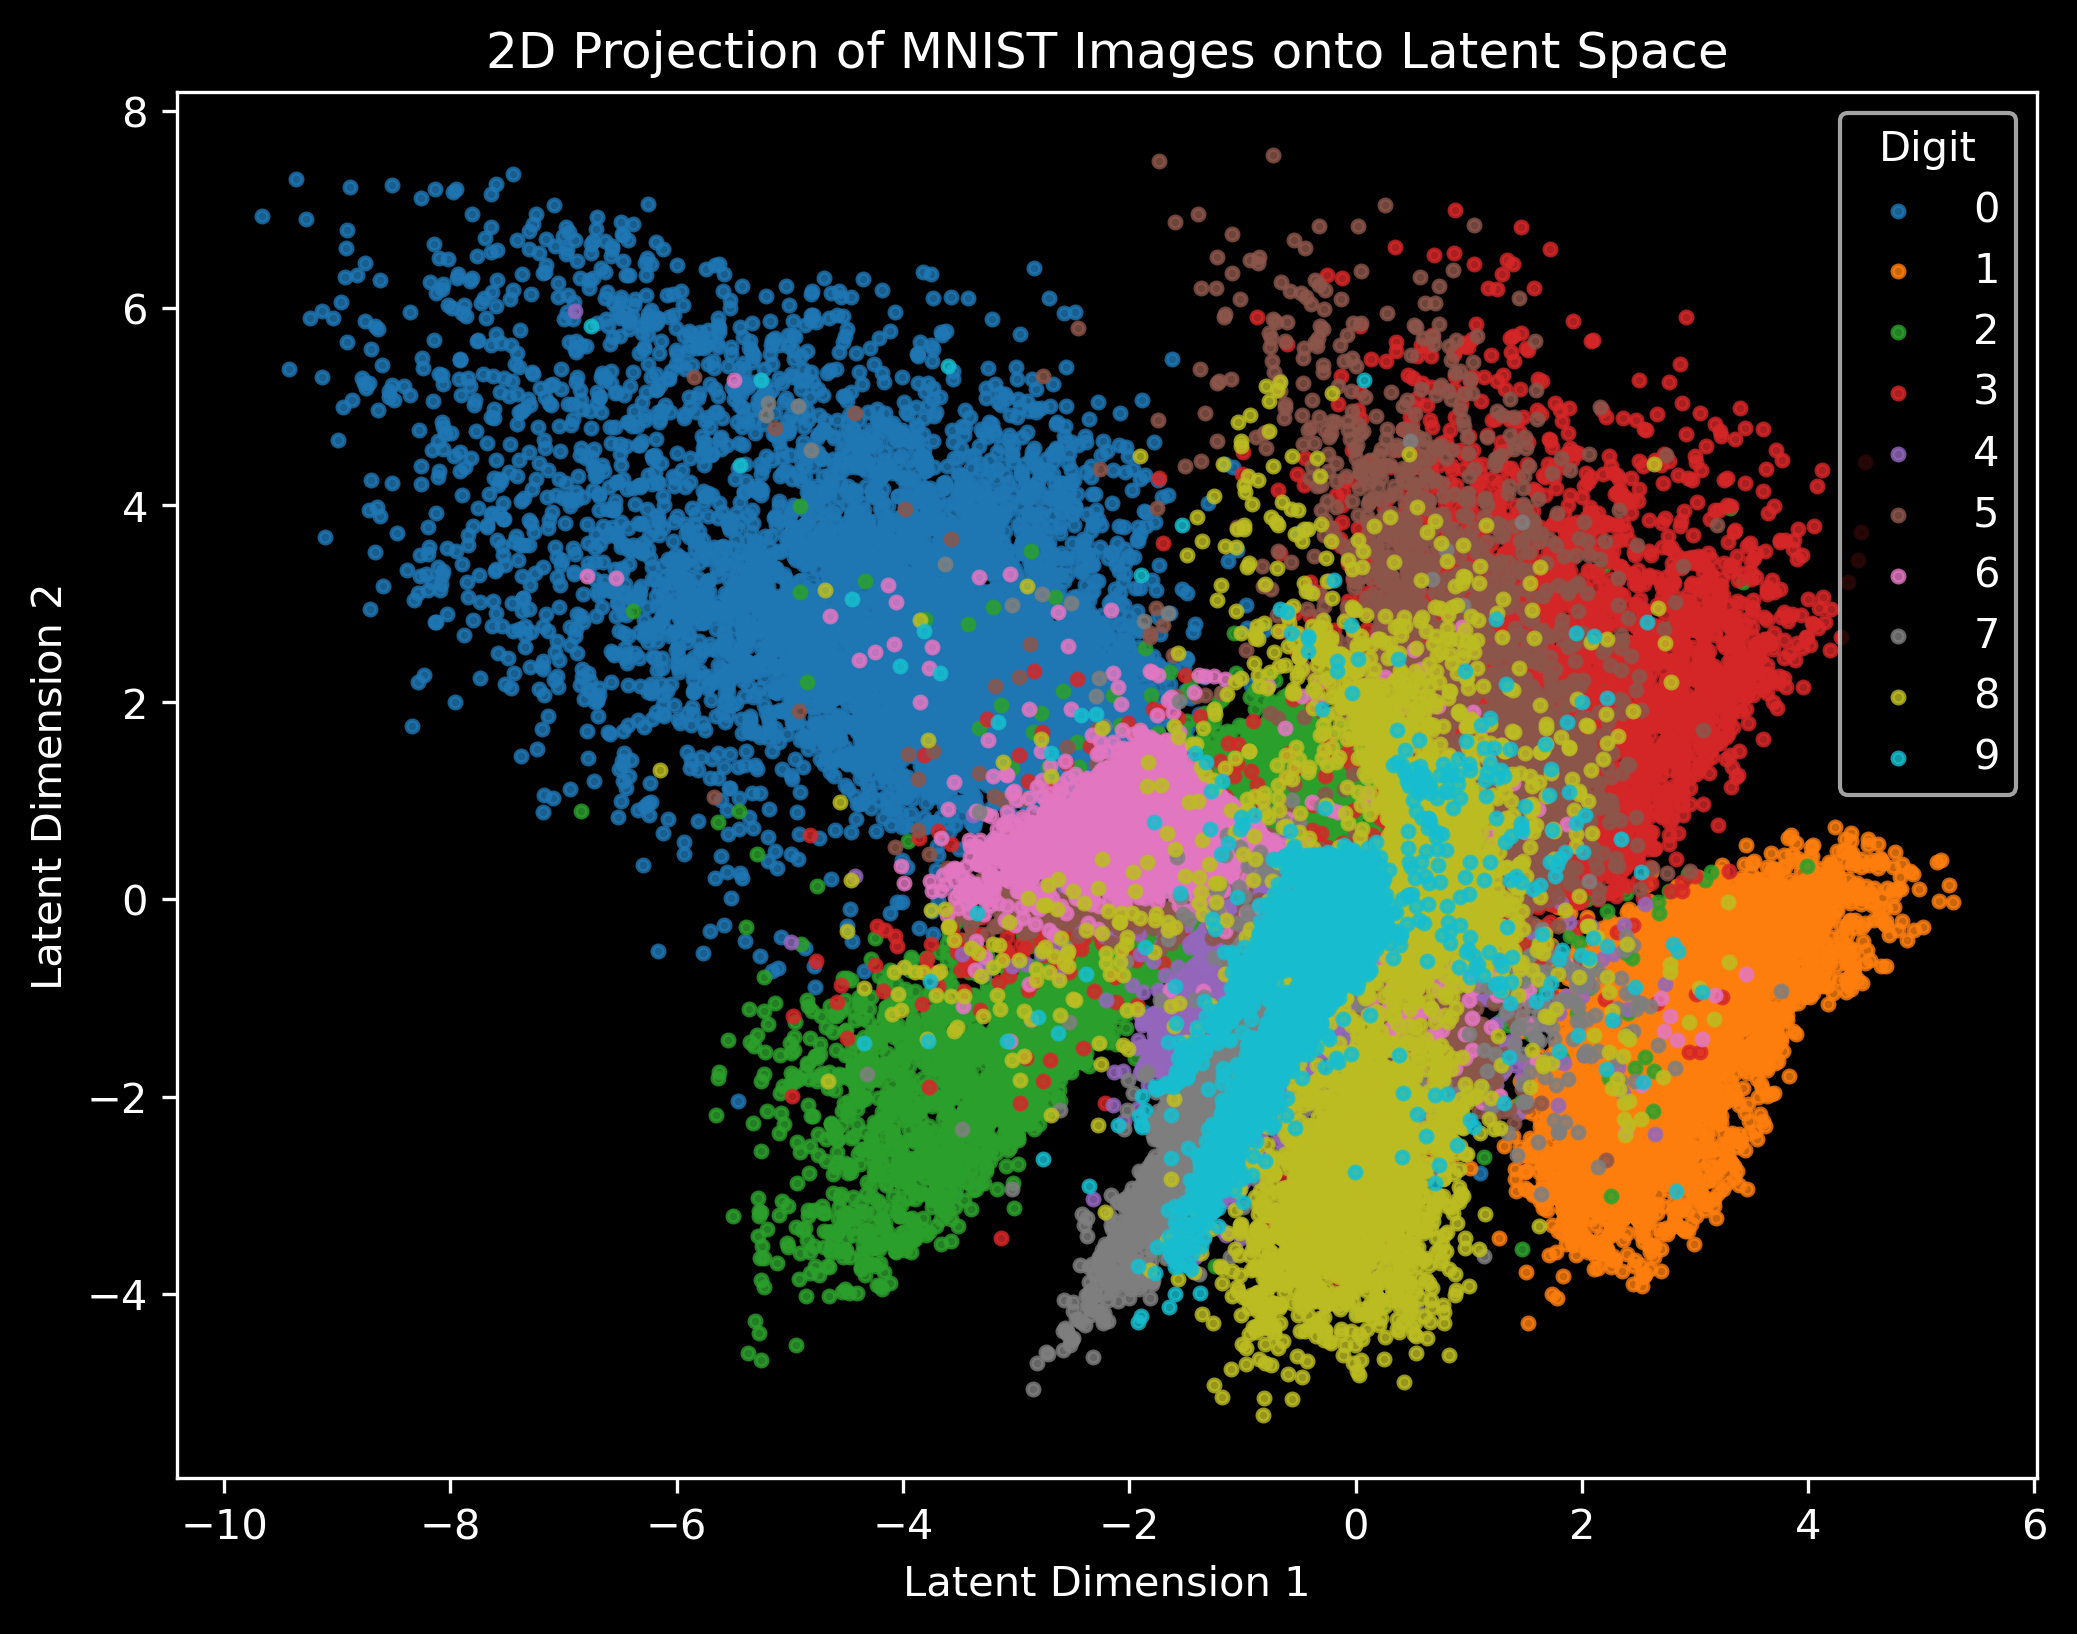

In [7]:
# Plot 2D Latent Space
plt.figure(figsize=(8, 6), dpi=300)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for class_label in range(10):
    indices = np.where(labels == class_label)
    plt.scatter(latent_space[indices, 0], latent_space[indices, 1], color=colors[class_label], label=str(class_label), alpha=0.8, s=8)
plt.legend(title="Digit", loc="upper right", fontsize=10)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Projection of MNIST Images onto Latent Space")
plt.show()

In [8]:
# Display Original and Reconstructed Images
def display_reconstructed_images(model, data_loader, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
    fig.suptitle("Original and Reconstructed Images", fontsize=16)

    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            images = images[:num_samples].to(device)
            reconstructed, _ = model(images)
            
            for j in range(num_samples):
                axes[0, j].imshow(images[j].cpu().squeeze(), cmap='gray')
                axes[0, j].axis("off")
                axes[0, j].set_title("Original")
            
            reconstructed_images = reconstructed.view(-1, 28, 28)
            for j in range(num_samples):
                axes[1, j].imshow(reconstructed_images[j].cpu().squeeze(), cmap='gray')
                axes[1, j].axis("off")
                axes[1, j].set_title("Reconstructed")

            break
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

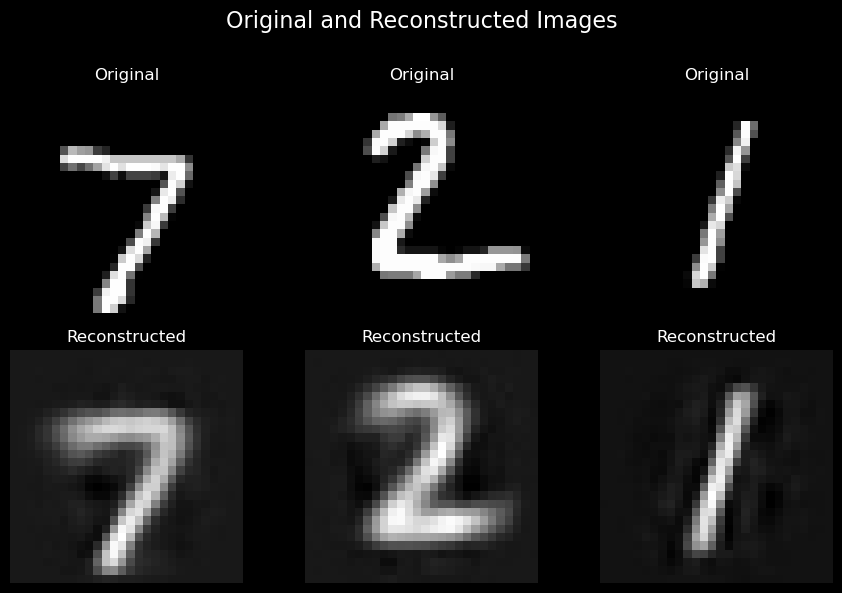

In [9]:
display_reconstructed_images(model, 
                             test_loader, 
                             num_samples=3)

In [10]:
# Sample from Latent Space and Visualize
def sample_from_latent_space(model, latent_coords, grid_shape=(2, 3)):
    model.eval()
    latent_coords = torch.tensor(latent_coords, dtype=torch.float32, device=device)

    with torch.no_grad():
        generated_images = model.decoder(latent_coords).view(-1, 28, 28).cpu()

    fig, axes = plt.subplots(*grid_shape, figsize=(grid_shape[1] * 3, grid_shape[0] * 3))
    fig.suptitle("Generated Images from Latent Space", fontsize=16)
    axes = axes.flatten()

    for i, image in enumerate(generated_images):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(f"Latent: {[round(x, 2) for x in latent_coords[i].tolist()]}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

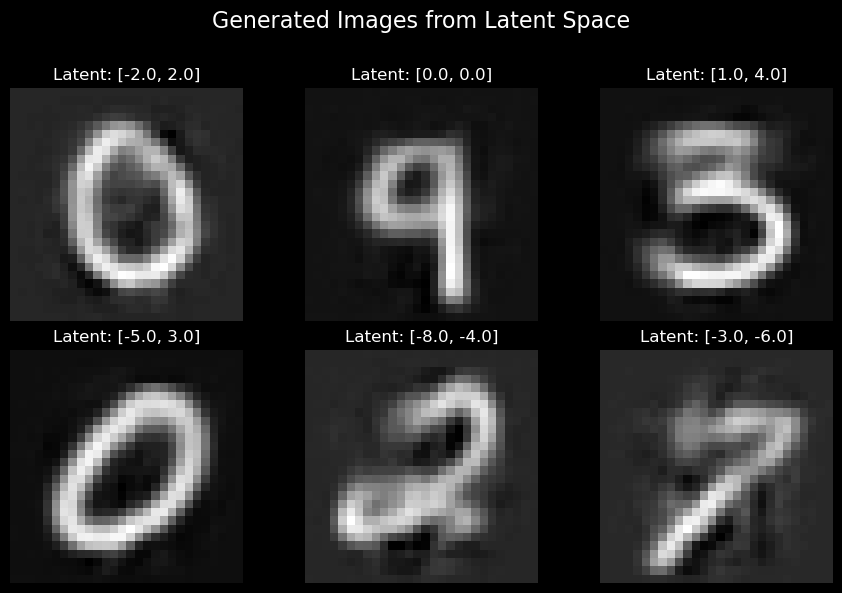

In [11]:
# Generate the arrays
latent_space_coords = [
    [-2, 2],
    [0, 0],
    [1, 4],
    [-5, 3],
    [-8, -4],
    [-3, -6]
]
sample_from_latent_space(model, 
                         latent_space_coords, 
                         grid_shape=(2, 3))

### Ideal Properties of a Latent Space

1. **Compactness**: Lower-dimensional than the input space, retaining key data features.

2. **Structured**: Similar inputs map to nearby points in latent space, aiding interpolation and generalization.

3. **Disentanglement**: Each dimension corresponds to an independent factor of variation in the data.

4. **Continuity**: Smooth latent space transitions correspond to smooth data changes (e.g., image generation).

5. **Generative**: Enables realistic data generation by sampling latent variables.

6. **Separation**: Different classes or categories are separable in latent space for improved classification/clustering.

7. **Invariance to Irrelevant Features**: Focuses on task-relevant features, ignoring noise.

8. **Smoothness**: Small latent space changes lead to coherent output variations.
